In [36]:
# merge_all.csv 파일을 사용하여 "가격 (원)" 컬럼의 값을 예측하는 모델을 만든다

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D

# load model
from keras.models import load_model

# import datatime
from datetime import datetime

# import rc
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [37]:
# 데이터 불러오기
df = pd.read_csv('data/merge_all/merge_all.csv')
df.head()

# 데이터 전처리
# "거래년월일" 컬럼을 인덱스로 설정
df = df.set_index('거래년월일')
# "평균" 컬럼을 배추가격으로 설정
df = df.rename(columns={'평균':'배추가격'})
df.head()

,자동차용 경유 가격 (원),전월비(%),배추가격,거래량
거래년월일,,,,
2000-01-01,583.35,4.0,5600.0,102285.0
2000-01-02,583.35,4.0,5600.0,102285.0
2000-01-03,583.35,4.0,5600.0,102285.0
2000-01-04,583.35,4.0,5600.0,715338.0
2000-01-05,583.35,4.0,5620.0,340568.0


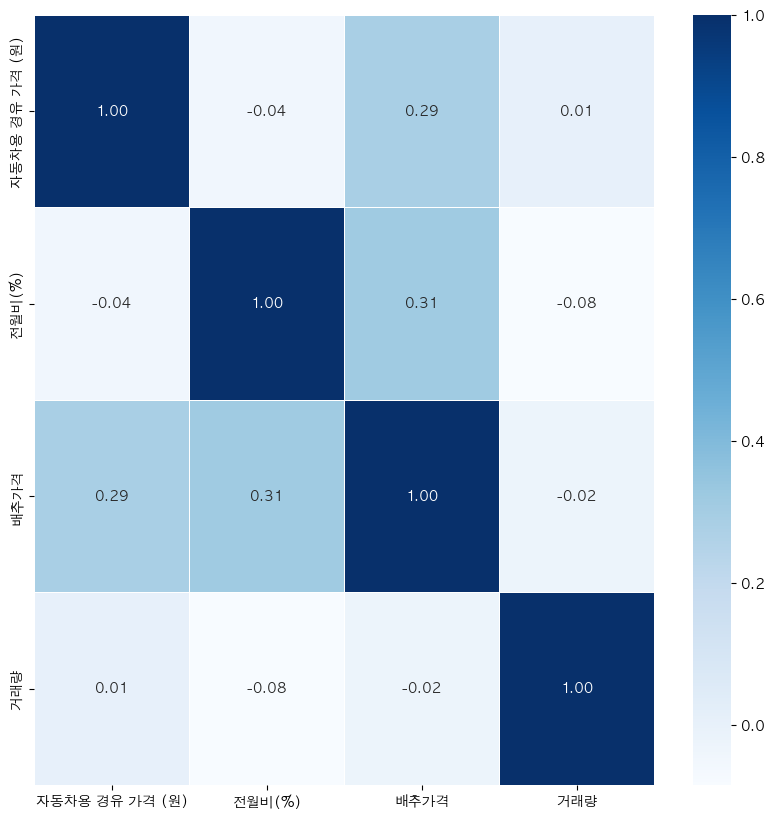

In [38]:
#  상관관계 분석
# 상관관계 분석을 위해 데이터 타입을 float로 변경
df = df.astype('float')

# 상관관계 분석
df.corr()



# 상관관계 시각화
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
plt.show()



In [39]:
# lstm 모델에 사용할 데이터를 만든다

# "배추가격"의 이동평균을 구한다
df['배추가격_1MA'] = df['배추가격'].rolling(window=1).mean()
df['배추가격_5MA'] = df['배추가격'].rolling(window=5).mean()
df['배추가격_10MA'] = df['배추가격'].rolling(window=10).mean()
df['배추가격_20MA'] = df['배추가격'].rolling(window=20).mean()

# 위에 코드를 함수로 만든다
def make_ma(df, col, ma_list):
    for ma in ma_list:
        df[col + '_' + str(ma) + 'MA'] = df[col].rolling(window=ma).mean()
    return df

# "배추가격"의 이동평균을 구한다
df = make_ma(df, '배추가격', [1, 5, 10, 20])

# "배추가격_N" 컬럼의 결측치를 제거한다
df = df.dropna()
df

,자동차용 경유 가격 (원),전월비(%),배추가격,거래량,배추가격_1MA,배추가격_5MA,배추가격_10MA,배추가격_20MA
거래년월일,,,,,,,,
2000-01-20,583.35,4.0,5850.0,155360.0,5850.0,5682.0,5667.0,5669.500
2000-01-21,583.35,4.0,5850.0,232952.0,5850.0,5726.0,5678.0,5682.000
2000-01-22,583.35,4.0,5850.0,247652.0,5850.0,5770.0,5700.0,5694.500
2000-01-23,583.35,4.0,5850.0,247652.0,5850.0,5810.0,5722.0,5707.000
2000-01-24,583.35,4.0,5890.0,687066.0,5890.0,5858.0,5748.0,5721.500
...,...,...,...,...,...,...,...,...
2022-11-26,1879.15,-8.0,6100.0,296250.0,6100.0,6132.0,6444.6,6698.275
2022-11-27,1879.15,-8.0,6100.0,296250.0,6100.0,6100.0,6411.4,6636.775
2022-11-28,1879.15,-8.0,5664.0,201478.0,5664.0,6012.8,6276.0,6560.300


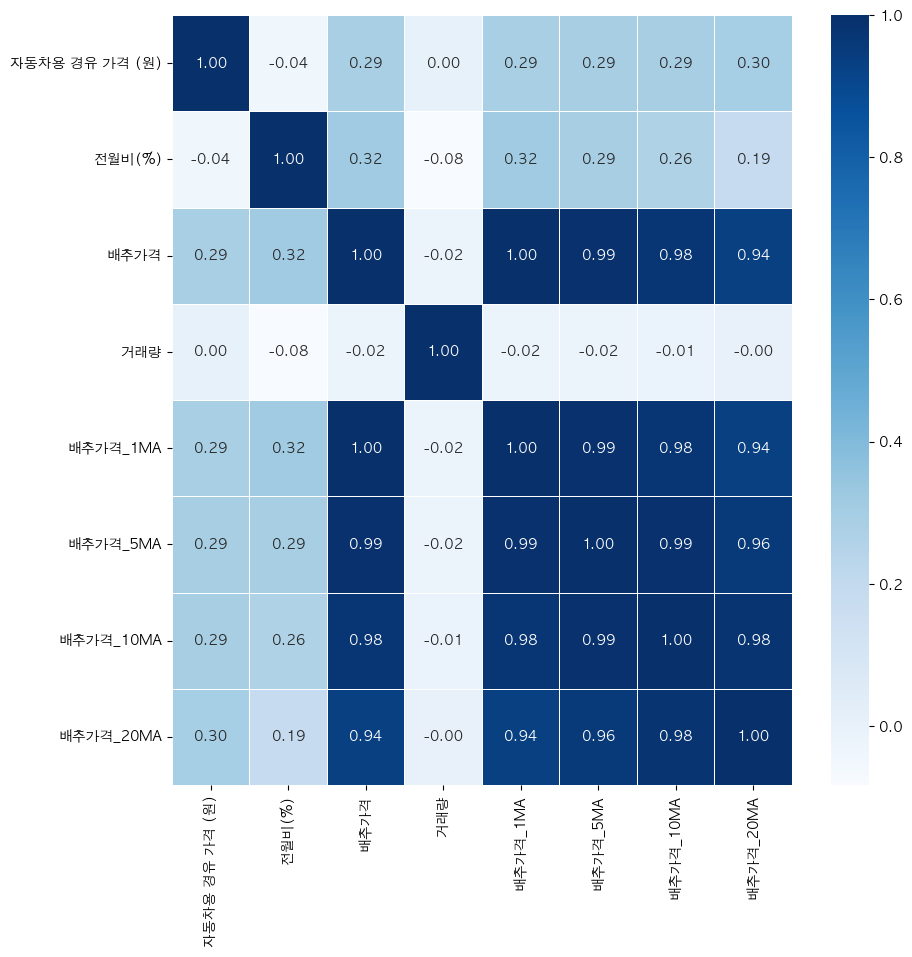

In [40]:
# 상관관계 분석
df.corr()

# 상관관계 시각화
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
plt.show()


In [41]:
# "거래량" 컬럼 삭제
df = df.drop('거래량', axis=1)
df.head()

,자동차용 경유 가격 (원),전월비(%),배추가격,배추가격_1MA,배추가격_5MA,배추가격_10MA,배추가격_20MA
거래년월일,,,,,,,
2000-01-20,583.35,4.0,5850.0,5850.0,5682.0,5667.0,5669.5
2000-01-21,583.35,4.0,5850.0,5850.0,5726.0,5678.0,5682.0
2000-01-22,583.35,4.0,5850.0,5850.0,5770.0,5700.0,5694.5
2000-01-23,583.35,4.0,5850.0,5850.0,5810.0,5722.0,5707.0
2000-01-24,583.35,4.0,5890.0,5890.0,5858.0,5748.0,5721.5


In [42]:
# "배추가격" 이외에 컬럼을 사용하여 "배추가격" 컬럼을 예측한다
# "배추가격_N" 컬럼을 X, "배추가격" 컬럼을 y로 설정한다
X = df.drop('배추가격', axis=1)
y = df['배추가격']

# 데이터를 학습용 데이터와 테스트용 데이터로 나눈다 (8:2)
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
y_train = y[:int(len(y)*0.8)]
y_test = y[int(len(y)*0.8):]

# 데이터를 학습용 데이터와 검증용 데이터로 나눈다 (8:2)
X_train = X_train[:int(len(X_train)*0.8)]
X_val = X_train[int(len(X_train)*0.8):]
y_train = y_train[:int(len(y_train)*0.8)]
y_val = y_train[int(len(y_train)*0.8):]

# 데이터를 정규화한다
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((5344, 6), (1069, 6), (1671, 6))

In [43]:
#  데이터를 3차원 배열로 변환한다
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train.shape, X_val.shape, X_test.shape


((5344, 6, 1), (1069, 6, 1), (1671, 6, 1))

In [44]:
#  모델을 만든다 relu, tanh, sigmoid, softmax, Maxpooling, Dropout, BatchNormalization
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], 1), activation='tanh'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))


# 모델을 컴파일한다
model.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [45]:
#  모델을 학습한다
early_stopping = EarlyStopping(patience=10)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100


2022-12-24 13:22:13.791635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-24 13:22:13.926664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/167 [..............................] - ETA: 3s - loss: 40047984.0000 - mse: 40047984.0000  

2022-12-24 13:22:14.095483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/167 [============================>.] - ETA: 0s - loss: 36832740.0000 - mse: 36832740.0000

2022-12-24 13:22:16.610441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-24 13:22:16.677296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 4s 17ms/step - loss: 36398976.0000 - mse: 36398976.0000 - val_loss: 19020388.0000 - val_mse: 19020388.0000
Epoch 2/100
167/167 [==============================] - 2s 14ms/step - loss: 10627024.0000 - mse: 10627024.0000 - val_loss: 11854178.0000 - val_mse: 11854178.0000
Epoch 3/100
167/167 [==============================] - 2s 14ms/step - loss: 5482808.0000 - mse: 5482808.0000 - val_loss: 2093392.0000 - val_mse: 2093392.0000
Epoch 4/100
167/167 [==============================] - 2s 14ms/step - loss: 1359285.3750 - mse: 1359285.3750 - val_loss: 539337.1875 - val_mse: 539337.1875
Epoch 5/100
167/167 [==============================] - 2s 14ms/step - loss: 587773.5000 - mse: 587773.5000 - val_loss: 278904.2188 - val_mse: 278904.2188
Epoch 6/100
167/167 [==============================] - 2s 14ms/step - loss: 342997.5000 - mse: 342997.5000 - val_loss: 161817.4219 - val_mse: 161817.4219
Epoch 7/100
167/167 [==============================] - 2s 13ms/ste

In [46]:
#  모델을 평가한다
model.evaluate(X_test, y_test)

53/53 [==============================] - 1s 12ms/step - loss: 196222.1562 - mse: 196222.1562


[196222.15625, 196222.15625]

In [47]:
#  모델을 사용한다
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_pred.shape


11/53 [=====>........................] - ETA: 0s 

2022-12-24 13:24:40.412985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-24 13:24:40.463987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 1s 5ms/step


(1671,)

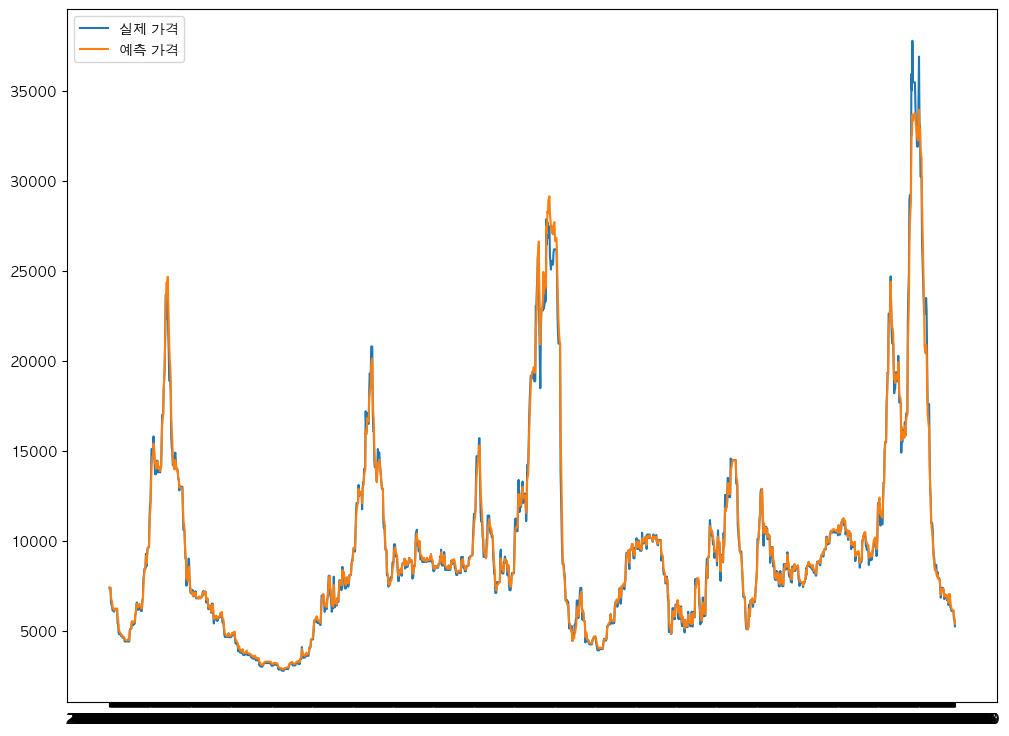

((1671,), (1671,))

In [48]:
#  모델을 시각화한다
plt.figure(figsize=(12, 9))
plt.plot(y_test, label='실제 가격')
plt.plot(y_pred, label='예측 가격')
plt.legend()
plt.show()

y_test.shape, y_pred.shape

In [49]:
#  모델 평가
# r2_score
r2_score(y_test, y_pred)


0.9937283916507615

In [50]:

#  mean_squared_error
mean_squared_error(y_test, y_pred)

196222.1547197386

In [51]:
#  모델을 저장한다
model.save('model/LSTM_s2s.h5')

In [52]:
#  모델을 불러온다
model = load_model('model/LSTM_s2s.h5')


In [53]:
# 2022년 12월 1일부터 2022년 12월 31일까지의 배추 가격을 예측한다
df['배추가격'] = model.predict(df)
df


ValueError: in user code:

    File "/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 6, 1), found shape=(None, 7)


새로운 데이터로 예측

In [ ]:
# read price_baechoo.csv
price_new = pd.read_csv('data/price/price_baechoo.csv')
# 2022년 12월 데이터만 추출
price_new = price_new[price_new['구분'].str.contains('2022-12')]
# "구분" 컬럼을 인덱스로 설정
price_new = price_new.set_index('구분')
# "평균" 컬럼을 배추가격으로 설정
price_new = price_new.rename(columns={'평균':'배추가격'})
price_new.head()

,배추가격
구분,
2022-12-01,5462.0
2022-12-05,5982.0
2022-12-06,5502.0
2022-12-07,5488.0
2022-12-08,5408.0


In [ ]:
# 새로운 y 값은 "배추가격" 컬럼이다
y_new = price_new['배추가격']

# 새로운 x 값을 생성한다
x_new = pd.DataFrame()



,배추가격_1,배추가격_5,배추가격_20,배추가격_40,배추가격_80
구분,,,,,


In [ ]:
#  데이터를 정규화한다
scaler = MinMaxScaler()
x_new = scaler.fit_transform(x_new)
x_new = x_new.reshape(x_new.shape[0], x_new.shape[1], 1)

x_new.shape

(13, 5, 1)

In [ ]:

#  데이터를 3차원 배열로 변환한다
X_new_3d = x_new.reshape(x_new.shape[0], x_new.shape[1], 1)

#  모델을 사용한다
y_pred_new = model.predict(X_new_3d)
y_pred_new = y_pred_new.reshape(-1)

#  예측결과 데이터프레임으로 만들기
y_pred_new = pd.DataFrame(y_pred_new, columns=['예측가격'])
y_pred_new

1/1 [==============================] - 0s 455ms/step


,예측가격
0,18.335093
1,18.335093
2,18.335093
3,18.335093
4,18.335093
5,18.335093
6,18.335093
7,18.335093
8,18.335093
9,18.335093
